# Tarea 2 : Clasificación y búsqueda por similitud de sketches usando redes convolucionales

# CC6204 Deep Learning, Universidad de Chile <br/> Hoja de respuestas 

## Nombre: Martín Cornejo Saavedra
Fecha para completar la tarea: 17 de junio de 2018

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from skimage.draw import line as drawLine

import pdb
import random
import os
import json

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Construcción del conjunto de datos

In [0]:
raw_categories = !gsutil ls -r "gs://quickdraw_dataset/full/simplified/*"

### Elegimos 100 categorias al azar y las descargamos

In [0]:
for idx, raw_cat in enumerate(raw_categories):
  raw_categories[idx] = raw_cat.replace(" ", "\ ")   # para que bash reconozca el espacio en la descarga

random_categories = []
max_num_categories = 5

while True:
  rand_cat = random.randint(0, len(raw_categories)-1)
  if rand_cat not in random_categories:
    random_categories.append(rand_cat)
  if len(random_categories) is max_num_categories:
    break

In [0]:
!mkdir quick_draw_data
os.chdir("/content/quick_draw_data")

In [0]:
str_random_cat = []

os.system("mkdir train")
os.system("mkdir test")

for category in random_categories:
  aux = raw_categories[category].replace("gs://quickdraw_dataset/full/simplified/", "")
  aux = aux.replace(".ndjson", "")
  str_random_cat.append(aux)
  os.system("mkdir train/" + aux)
  os.system("mkdir test/" + aux)

In [12]:
for idx, category in enumerate(random_categories):
  os.system("gsutil cp " + raw_categories[category] + " .")
  print("La categoria " + str(idx+1) + " copiada es " + raw_categories[category])

La categoria 1 copiada es gs://quickdraw_dataset/full/simplified/speedboat.ndjson
La categoria 2 copiada es gs://quickdraw_dataset/full/simplified/school\ bus.ndjson
La categoria 3 copiada es gs://quickdraw_dataset/full/simplified/donut.ndjson
La categoria 4 copiada es gs://quickdraw_dataset/full/simplified/hot\ tub.ndjson
La categoria 5 copiada es gs://quickdraw_dataset/full/simplified/bread.ndjson


In [13]:
categories = !ls
print(len(categories))

for cat in str_random_cat:
  if (cat + ".ndjson").replace("\ ", " ") not in categories:
    print("falta " + cat)

7


### Se convierte la data en formato json a bitmaps de 128x128 y se guardan en formato .txt

In [0]:
def parse_line(ndjson_line):
  """Parse an ndjson line and return ink (as np array) and classname."""
  sample = json.loads(ndjson_line)
  class_name = sample["word"]
  if not class_name:
    print ("Empty classname")
    return None, None
  inkarray = sample["drawing"]

  div_scale = 2
  
  for idx, stroke in enumerate(inkarray):
    if len(stroke[0]) != len(stroke[1]):
      print("Inconsistent number of x and y coordinates.")
      return None, None
    
    for idy, x_coord in enumerate(stroke[0]):
      inkarray[idx][0][idy] /= div_scale
      inkarray[idx][1][idy] /= div_scale
  
  return inkarray, class_name

def convert_data(trainingdata_dir,
                 observations_per_class,
                 output_folder,
                 offset=0):
  file_handles = []
  # Open all input files.
  for filename in sorted(tf.gfile.ListDirectory(trainingdata_dir)):
    if not filename.endswith(".ndjson"):
      #print("Skipping", filename)
      continue
    file_handles.append(
        tf.gfile.GFile(os.path.join(trainingdata_dir, filename), "r"))
    if offset:  # Fast forward all files to skip the offset.
      count = 0
      for _ in file_handles[-1]:
        count += 1
        if count == offset:
          break

    
  reading_order = list(range(len(file_handles)))
          
  class_names = []  
    
  for idx in reading_order:
    for pictureNum in range(observations_per_class):
      line = file_handles[idx].readline()
      ink = None
      
      while ink is None:
        ink, class_name = parse_line(line)
        if ink is None:
          print ("Couldn't parse ink from '" + line + "'.")

      drawing = np.zeros((128, 128), dtype=np.uint8)
      
      if class_name not in class_names:
        class_names.append(class_name)      
        os.system("mkdir " + output_folder + str(idx))

      for linea in ink:
        for idy in range(len(linea[0])-1):
          rr, cc = drawLine(linea[1][idy], linea[0][idy], linea[1][idy+1], linea[0][idy+1])
          drawing[rr, cc] = 1

      np.savetxt(output_folder + str(idx) + "/" + str(pictureNum) + ".txt", drawing, fmt="%d", delimiter=" ")

In [0]:
train_samples_per_cat = 50

convert_data(".",
             train_samples_per_cat,
             "train/")    

test_samples_per_cat = 10

convert_data(".",
             test_samples_per_cat,
             "test/",
             train_samples_per_cat)    

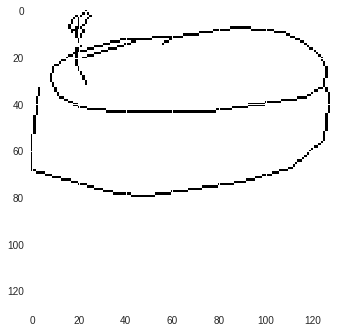

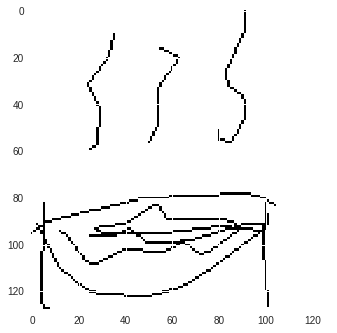

In [16]:
test_imagen = np.loadtxt("test/2/9.txt")
plt.imshow(test_imagen)
plt.show()

train_imagen = np.loadtxt("train/2/49.txt")
plt.imshow(train_imagen)
plt.show()

In [35]:
!ls test/4

0.txt  1.txt  2.txt  3.txt  4.txt  5.txt  6.txt  7.txt	8.txt  9.txt


### Se construye el grafo de la skNet

In [0]:
def deepnn(x):
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 128, 128, 1])       

  conv1_1 = tf.layers.conv2d(
    inputs=x_image,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_2 = tf.layers.conv2d(
    inputs=conv1_1,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)

  pool1 = tf.layers.max_pooling2d(inputs=conv1_2, pool_size=[3, 3], strides=2)

  # Dense layer
  
  pool2_flat = tf.reshape(pool1, [-1, 63 * 63 * 64])
  dense_l = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  
  # Logits Layer
  
  logits = tf.layers.dense(inputs=dense_l, units=max_num_categories)
  
  return logits


def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

### Se crea una clase para extraer datos de entrenamiento

In [0]:
class QuickDataset():
  def __init__(self):    
    self.x = []
    self.y = []
    
    train_data_path = "train"
    
    for idx in range(max_num_categories):
      folder = "/" + str(idx)
  
      for idy in range(train_samples_per_cat):
           
        train_input = np.loadtxt(train_data_path+folder + "/" + str(idy) + ".txt")
        self.x.append(np.resize(train_input, (1, 16384))[0])
        #self.y.append(np.eye(max_num_categories)[np.array(idx)])
        self.y.append(idx)
  
  def paquetes(self, B):
       
    if not hasattr(self, 'arr_paquetes'):
      n_iters = int(len(self.x)/B)
      arr_paquetes = []
   
      for index in range(n_iters):
        arr_paquetes.append(self.elige_batch(self.x,self.y,B))
              
      self.arr_paquetes = arr_paquetes
      
    return self.arr_paquetes
  
  def elige_batch(self, X, Y, b):
    N = len(self.x)
    x_lista = []
    y_lista = []
  
    for _ in range(b):
      i = np.random.randint(N)
      x_lista.append(X[i:i+1])
      y_lista.append(Y[i:i+1])
  
    x = np.concatenate(x_lista, axis=0)
    y = np.concatenate(y_lista, axis=0)
  
    return x, y
  
dataset = QuickDataset()

In [22]:
x = tf.placeholder(tf.float16, shape=(None, 128*128))
y_ = tf.placeholder(tf.int64, shape=(None))
y_conv = deepnn(x)
    
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_,
                                                          logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy)

# hiperparámetros de entrenamiento
batch_size = 10
n_epochs = 5
batches_per_epoch = train_samples_per_cat * max_num_categories / batch_size
learning_rate=0.1

train_step = tf.train.GradientDescentOptimizer(learning_rate)
train_step = train_step.minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

loss_array = []
train_acc = []
val_acc = []
test_acc = []   
cnf_matrix = []


with tf.Session() as sess:
  init = tf.global_variables_initializer()
  init.run()    
  for idz in range(n_epochs):
    batches = dataset.paquetes(batch_size)
    
    for idx, batch in enumerate(batches): 
      if idx % 5 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
        print('step %d, training set accuracy %g' % (idx, train_accuracy))      
      
      sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})

step 0, training set accuracy 0.2
step 5, training set accuracy 0.6
step 10, training set accuracy 0.4
step 15, training set accuracy 0.8
step 20, training set accuracy 0.7
step 0, training set accuracy 0.9
step 5, training set accuracy 0.7
step 10, training set accuracy 0.9
step 15, training set accuracy 1
step 20, training set accuracy 0.8
step 0, training set accuracy 1
step 5, training set accuracy 1
step 10, training set accuracy 1
step 15, training set accuracy 1
step 20, training set accuracy 1
step 0, training set accuracy 1
step 5, training set accuracy 1
step 10, training set accuracy 1
step 15, training set accuracy 1
step 20, training set accuracy 1
step 0, training set accuracy 1
step 5, training set accuracy 1
step 10, training set accuracy 1
step 15, training set accuracy 1
step 20, training set accuracy 1
